In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas_datareader.data as pdr
from cytoolz import sliding_window
import pickle
from itertools import groupby

In [2]:
def test_increasing_value(v):
    if(v>0):
        return 1
    else:
        return 0

def test_decreasing_value(v):
    if(v<0):
        return 1
    else:
        return 0


In [3]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [4]:
def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

In [5]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [6]:
#today = datetime.today().strftime('%Y-%m-%d')
today = end

#past = (datetime.strptime(today, '%Y-%m-%d') - relativedelta(months=21)).strftime('%Y-%m-%d')
past = start

In [7]:
  
indexes_df = pd.DataFrame()

for s in indexes[0].values:
    indexes_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],indexes_df],axis=1)
    
indexes_df.columns = indexes[0].values

indexes_df_qtr_pvt = indexes_df.asfreq('d').interpolate().resample('W').mean().pct_change()

sectors_df = pd.DataFrame()

for s in sectors[0].values:
    sectors_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],sectors_df],axis=1)
    
sectors_df.columns = sectors[0].values

sectors_df_qtr_pvt = sectors_df.asfreq('D').interpolate().asfreq('d').interpolate().resample('W').mean()

combined_indexes_sectors_df = pd.concat([indexes_df_qtr_pvt,sectors_df_qtr_pvt],axis=1)
combined_indexes_sectors_return_pvt_df = combined_indexes_sectors_df.asfreq('d').interpolate().resample('W').mean().pct_change().dropna()

In [8]:
cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=USA&separator=comma&csv-lang=en")
#cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [9]:
bci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [10]:
cci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [11]:
np.unique(cci_df.LOCATION)

array(['AUS', 'AUT', 'BEL', 'BRA', 'CHE', 'CHL', 'CHN', 'COL', 'CRI',
       'CZE', 'DEU', 'DNK', 'EA19', 'ESP', 'EST', 'FIN', 'FRA', 'G-7',
       'GBR', 'GRC', 'HUN', 'IDN', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR',
       'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NZL', 'OECD', 'OECDE', 'POL',
       'PRT', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF'],
      dtype=object)

In [12]:
bci_df_USA = bci_df[bci_df['LOCATION']=='USA']
bci_df_USA.index = bci_df_USA[bci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cci_df_USA = cci_df[cci_df['LOCATION']=='USA']
cci_df_USA.index = cci_df_USA[cci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cli_df_USA = cli_df[cli_df['LOCATION']=='USA']
cli_df_USA.index = cli_df_USA[cli_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))

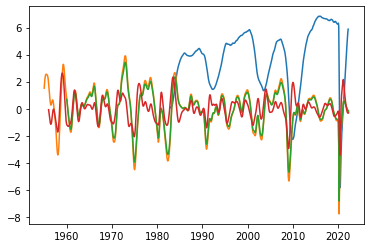

In [13]:
USALOLITONOSTSAM = pdr.DataReader('USALOLITONOSTSAM','fred','1955-01-01',today)-100

USPHCI = pdr.DataReader('USPHCI','fred','1955-01-01',today)
USPHCI_signal = USPHCI.rolling(4).mean()-USPHCI.rolling(12*4).mean()
plt.plot(USPHCI_signal)

"""
signal = USALOLITONOSTSAM['USALOLITONOSTSAM']

Recovery = (signal<0)*(signal.pct_change(1)>0)
Expansion = (signal>0)*(signal.pct_change(1)>0)
Slowdown = (signal>0)*(signal.pct_change(1)<0)
Recession = (signal<0)*(signal.pct_change(1)<0)
"""
combined_leading = pd.concat([cli_df_USA['Value']-100,USALOLITONOSTSAM],axis=1)

#signal = combined_leading.mean(axis=1)
#signal = combined_leading.mean(axis=1).asfreq('d').interpolate().asfreq('q')
signal = combined_leading.mean(axis=1).asfreq('d').interpolate().resample('W').mean()

#QTR_SMA = cli_df_USA['Value'].rolling(3).mean()
ST_SMA = signal.rolling(13).mean()
LT_SMA = signal.rolling(52).mean()
#troughs
troughs = signal.rolling(52).min()
#troughs = signal_trough

#peaks
peaks = signal.rolling(52).max()
#peaks = signal_peak

signal_MACD = ST_SMA - LT_SMA

plt.plot(combined_leading)
plt.plot(signal_MACD)
plt.show()

In [14]:
#cli_range_df = cli_df_USA[(cli_df_USA.index<=today) & (cli_df_USA.index>=past)]

In [96]:
np.sum((business_cycle['signal']!=business_cycle['signal_trough']))

2448

In [15]:
#plt.plot(USPHCI.pct_change())

,signal,signal_trough,signal_peak,signal_ST_SMA,signal_LT_SMA
1955-01-02,1.522034,NaN,NaN,NaN,NaN
1955-01-09,1.574539,NaN,NaN,NaN,NaN
1955-01-16,1.656213,NaN,NaN,NaN,NaN
1955-01-23,1.737887,NaN,NaN,NaN,NaN
1955-01-30,1.819561,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-03,-0.159762,-0.159762,0.619059,-0.097259,0.232398
2022-04-10,-0.164293,-0.164293,0.619059,-0.108929,0.217748
2022-04-17,-0.168131,-0.168131,0.619059,-0.119657,0.202884
2022-04-24,-0.171970,-0.171970,0.619059,-0.129444,0.187806


In [97]:
slowdown = (business_cycle['signal_ST_SMA']<business_cycle['signal_ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['signal_peak'])# & (business_cycle['signal']!=business_cycle['signal_trough'])#
np.sum(slowdown)

1012

In [16]:


signal_trough = troughs#signal.rolling(12*4).min()
signal_peak = peaks#signal.rolling(12*4).max()

signal_ST_SMA = ST_SMA#signal.rolling(12).mean()
signal_LT_SMA = LT_SMA#signal.rolling(12*4).mean()

1955-01-02         NaN
1955-01-09         NaN
1955-01-16         NaN
1955-01-23         NaN
1955-01-30         NaN
                ...   
2022-04-03    0.062503
2022-04-10    0.055364
2022-04-17    0.048474
2022-04-24    0.042525
2022-05-01    0.037518
Freq: W-SUN, Length: 3514, dtype: float64

In [175]:
business_cycle = pd.concat([signal,signal_trough,signal_peak,signal_ST_SMA,signal_LT_SMA],axis=1)
business_cycle.columns = ["signal","signal_trough","signal_peak","signal_ST_SMA","signal_LT_SMA"]

expansion = (business_cycle['signal_ST_SMA']>business_cycle['signal_LT_SMA']) #& (business_cycle['signal']==business_cycle['signal_peak'])
#recovery = (business_cycle['signal_ST_SMA']>business_cycle['signal_ST_SMA'].shift(1)) & (business_cycle['signal']>business_cycle['signal_trough']) & (business_cycle['signal_ST_SMA']<business_cycle['signal_LT_SMA']) #& (business_cycle['signal_ST_SMA']<business_cycle['signal_LT_SMA'])
recovery = (expansion==False) & (business_cycle['signal']>business_cycle['signal_trough'])
expansion = (expansion) & (recovery==False)
#expansion = (business_cycle['signal_ST_SMA']>business_cycle['signal_LT_SMA'])
#slowdown = (combined['signal_ST_SMA']>combined['signal_LT_SMA']) & (combined['signal']<combined['signal_peak'])

#slowdown = (business_cycle['signal_ST_SMA']<business_cycle['signal_ST_SMA'].shift(1)) & (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['signal_peak']) & (business_cycle['signal']!=business_cycle['signal_trough'])
slowdown = (business_cycle['signal_ST_SMA']<business_cycle['signal_ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['signal_peak'])# & (business_cycle['signal']!=business_cycle['signal_trough'])#
np.sum(slowdown)
#recession = (combined['signal_ST_SMA']<combined['signal_LT_SMA']) & (combined['signal']==combined['signal_trough'])
#if yesterday's difference less than today's difference
#recession = (business_cycle['signal_ST_SMA']<business_cycle['signal_LT_SMA']) & (business_cycle['signal']==business_cycle['signal_trough']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(business_cycle['signal'].pct_change().shift(1)))

#recession = ((business_cycle['signal_peak']-business_cycle['signal_trough'])>(business_cycle['signal_peak']-business_cycle['signal_trough']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['signal_ST_SMA']) & (((business_cycle['signal']<business_cycle['signal_ST_SMA']) & ((business_cycle['signal_ST_SMA']-business_cycle['signal'])>(((business_cycle['signal_ST_SMA']-business_cycle['signal']).shift(1))))))
recession = ((business_cycle['signal']==business_cycle['signal_trough'])&((business_cycle['signal_ST_SMA']-business_cycle['signal'])/(business_cycle['signal_peak']-business_cycle['signal'])>.25)) #\
#& ((business_cycle['signal_peak']-business_cycle['signal_trough'])>(business_cycle['signal_peak']-business_cycle['signal_trough']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['signal_ST_SMA']) & (((business_cycle['signal']<business_cycle['signal_ST_SMA']) & ((business_cycle['signal_ST_SMA']-business_cycle['signal'])>(((business_cycle['signal_ST_SMA']-business_cycle['signal']).shift(1))))))

#recession = (business_cycle['signal_trough']<business_cycle['signal_trough'].shift(1))&(abs(business_cycle['signal_trough'].pct_change())>abs(business_cycle['signal_trough'].pct_change()).shift(1))
#((business_cycle['signal']<business_cycle['signal_ST_SMA'])&(abs(business_cycle['signal']<business_cycle['signal_ST_SMA']))>(abs(business_cycle['signal_LT_SMA']-business_cycle['signal_ST_SMA'])))

#recession = (business_cycle['signal_ST_SMA']<business_cycle['signal_LT_SMA']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(2*business_cycle['signal'].pct_change().shift(1))) & (business_cycle['signal_ST_SMA']<business_cycle['signal_ST_SMA'].shift(1)) & (abs(business_cycle['signal_ST_SMA'].pct_change())>abs(business_cycle['signal_ST_SMA'].pct_change().shift(1))) \
#& ((business_cycle['signal_peak']-business_cycle['signal_trough'])>(business_cycle['signal_peak']-business_cycle['signal_trough']).shift(1))
slowdown = (slowdown) & (slowdown!=recession) & (slowdown!=recovery) & (slowdown!=expansion)

business_cycle = pd.concat([business_cycle,recovery,expansion,slowdown,recession],axis=1)
business_cycle = business_cycle.dropna()
business_cycle.columns = [*business_cycle.columns[0:5],'recovery','expansion','slowdown','recession']
#slowdown = combined['signal_ST_SMA']<combined['signal_LT_SMA']

In [178]:
(business_cycle['signal']<business_cycle['signal_ST_SMA']) & (business_cycle['signal_ST_SMA']-business_cycle['signal'])>(2*((business_cycle['signal_ST_SMA']-business_cycle['signal']).shift(1)))

1955-12-25    False
1956-01-01     True
1956-01-08     True
1956-01-15     True
1956-01-22     True
              ...  
2022-04-03     True
2022-04-10     True
2022-04-17     True
2022-04-24     True
2022-05-01     True
Freq: W-SUN, Length: 3463, dtype: bool

1955-12-25         NaN
1956-01-01    0.635949
1956-01-08    0.679295
1956-01-15    0.727128
1956-01-22    0.776279
                ...   
2022-04-03    0.136130
2022-04-10    0.125005
2022-04-17    0.110727
2022-04-24    0.096948
2022-05-01    0.085051
Freq: W-SUN, Length: 3463, dtype: float64

274

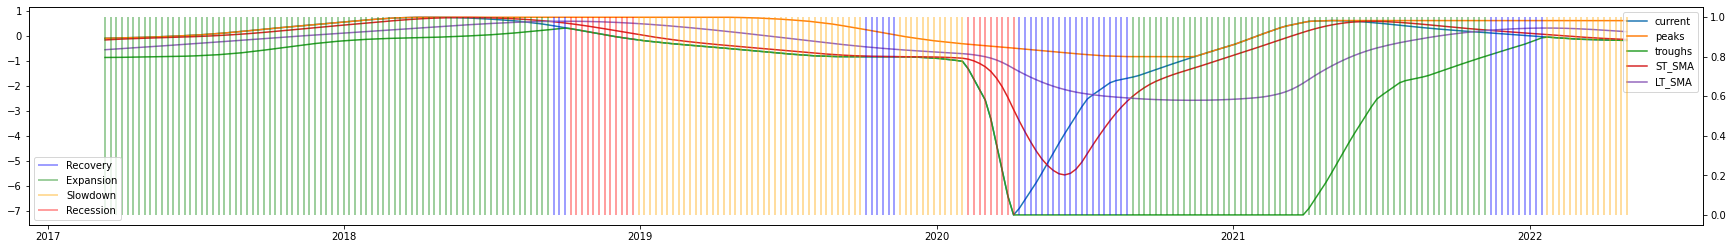

In [176]:
fig, ax1 = plt.subplots( figsize=(30,4) )
#plt.plot(cli_df_USA['Value'])
plt.plot(business_cycle['signal'].reindex(combined_indexes_sectors_return_pvt_df.index))

plt.plot(business_cycle['signal_peak'].reindex(combined_indexes_sectors_return_pvt_df.index))
plt.plot(business_cycle['signal_trough'].reindex(combined_indexes_sectors_return_pvt_df.index))
plt.plot(business_cycle['signal_ST_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
plt.plot(business_cycle['signal_LT_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
plt.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax2.plot(Expansion)

#ax2.legend(['Recovery'],loc=2)

#ax2.plot(Slowdown)
#ax2.plot(Recession)

#ax2.plot(Expansion)

#ax2.legend(['Recovery','Recession','Expansion'],loc=2)
#ax2.legend(['Slowdown','Recession'],loc=2)

#ax3.axhline(y = 0, color = 'r', linestyle = '-')
#ax2.plot(signal)
#If st is less than lt
#ax2.plot((signal>0))

#ax2.plot(signal_peak)
#ax2.plot(signal_trough)
"""
ax2.plot(Recovery)
ax2.plot(Expansion)
ax2.plot(Slowdown)
ax2.plot(Recession)
"""
#ax2.legend(['Recession'],loc=2)

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

#ax2.axhline(1, color='green', lw=2, alpha=0.5)
#ax2.axhline(1, color='red', lw=2, alpha=0.5)

"""
ax2.fill_between(business_cycle.index, 0, 1, where=Recovery['USPHCI'].reindex(business_cycle.index) == 1,facecolor='blue', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Expansion['USPHCI'].reindex(business_cycle.index) == 1,facecolor='orange', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Slowdown['USPHCI'].reindex(business_cycle.index) == 1,facecolor='green', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Recession['USPHCI'].reindex(business_cycle.index) == 1,facecolor='red', alpha=0.5, transform=trans)
"""   
 
ax2.vlines((recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='blue', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recovery')
#ax2.fill_between(combined_indexes_sectors_return_pvt_df.index, 0, 1, where=Recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1,facecolor='blue', alpha=0.2, transform=trans)
#ax2.axhspan(Recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1,facecolor='blue', alpha=0.2, transform=trans,)
#(459.25, 525.25,
#ax2.fill_between(combined_indexes_sectors_return_pvt_df.index, 0, 1, where=Expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1,facecolor='green', alpha=0.2, transform=trans)
ax2.vlines((expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='green', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Expansion')
#ax2.fill_between(combined_indexes_sectors_return_pvt_df.index, 0, 1, where=Slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1,facecolor='orange', alpha=0.2, transform=trans)
ax2.vlines((slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='orange', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Slowdown')
#ax2.fill_between(combined_indexes_sectors_return_pvt_df.index, 0, 1, where=Recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1,facecolor='red', alpha=0.2, transform=trans)
ax2.vlines((recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='red', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recession')

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)
plt.show()
#plt.savefig("output.jpg")

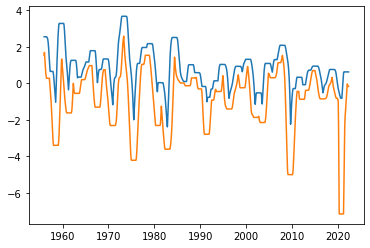

In [179]:
plt.plot(business_cycle[['signal_peak','signal_trough']])

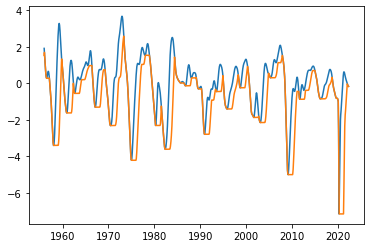

In [49]:
plt.plot(business_cycle[['signal','signal_trough']])

In [50]:
np.where(slowdown&recession)

(array([], dtype=int64),)

In [51]:
np.where(recovery&expansion)

(array([], dtype=int64),)

In [52]:
np.sum(business_cycle.iloc[:,-4:])

recovery     1425
expansion    1023
slowdown        0
recession     418
dtype: int64

In [53]:
np.sum(np.sum(business_cycle.iloc[:,-4:]))

2866

In [54]:
#Slowdown = (signal_ST_SMA < signal_peak)
#np.sum(Slowdown)

In [55]:
"""
Slowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)
Slowdown = (signal.pct_change()<0) * (signal<signal_peak)# (ST_SMA<LT_SMA)
np.sum(Slowdown)
"""

"\nSlowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)\nSlowdown = (signal.pct_change()<0) * (signal<signal_peak)# (ST_SMA<LT_SMA)\nnp.sum(Slowdown)\n"

In [56]:
#The LEI Index YoY changes are positive and above long-term trends
#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))

#***
#Expansion = (signal>signal_LT_SMA) * (signal_ST_SMA.pct_change()>0) * (signal>signal.shift(1))

#Expansion = (signal>signal_LT_SMA) * np.logical_or(((signal_ST_SMA>signal_LT_SMA).values),((signal_ST_SMA.pct_change()>0).values))# * (signal>signal.shift(1))
Expansion =  (signal>signal.shift(1)) * np.logical_or(((signal_ST_SMA>signal_LT_SMA).values),((signal_ST_SMA.pct_change()>0).values))# *
np.sum(Expansion)

#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))
Recovery = (signal > signal_trough) * (signal>signal.shift(1)) * (Expansion==0) * (signal<signal_LT_SMA)
np.sum(Recovery)

print(np.sum(Recovery*Expansion))

Declining = ((Recovery!=1)*(Expansion!=1))
print(np.sum(Declining))

###Recession

today_minus_yesterday = signal-signal.shift(1)

yesterday_minus_today = signal.shift(1)-signal

#rapidly declines to a trough

#today is less than yesterday
#at an accelerating pace OR
    #yesterday was receding
#Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values|(today_minus_yesterday.shift(1)<0).values)) # * (signal == signal_trough))
Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values)) * (signal == signal_trough)

print(np.sum(Recession))

#prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]

Not_recession = (Recession==0)*(Recovery==0)*(Expansion==0)#*(signal<signal_peak)
Slowdown = Not_recession
print(Slowdown)

#Slowdown = (ST_SMA < peaks)

0
1802
369
1955-01-02     True
1955-01-09     True
1955-01-16     True
1955-01-23     True
1955-01-30     True
              ...  
2022-04-03     True
2022-04-10     True
2022-04-17     True
2022-04-24    False
2022-05-01     True
Freq: W-SUN, Length: 3514, dtype: bool


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the b

In [57]:
#plt.plot(prior_recession * Slowdown['USPHCI'])

In [58]:
"""
print(np.sum(Slowdown))

while (np.sum(prior_recession * Slowdown['USPHCI'])>0):
     
    positions = prior_recession * Slowdown['USPHCI']
    
    #print(np.where(positions))
    
    Recession.iloc[positions] = True
    Slowdown.iloc[positions] = False

    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)
    #positions = np.intersect1d(prior_recession,Slowdown)
    #Recession.iloc[positions] = True
    #Slowdown.iloc[positions] = False
    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)
    
    
    
    #print(np.sum(Slowdown))

    
"""

"\nprint(np.sum(Slowdown))\n\nwhile (np.sum(prior_recession * Slowdown['USPHCI'])>0):\n     \n    positions = prior_recession * Slowdown['USPHCI']\n    \n    #print(np.where(positions))\n    \n    Recession.iloc[positions] = True\n    Slowdown.iloc[positions] = False\n\n    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)\n    #positions = np.intersect1d(prior_recession,Slowdown)\n    #Recession.iloc[positions] = True\n    #Slowdown.iloc[positions] = False\n    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<signal_peak)\n    \n    \n    \n    #print(np.sum(Slowdown))\n\n    \n"

In [59]:
"""
list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
print(count_dups)
"""

#business_cycle = pd.concat([signal,Recovery,Expansion,Slowdown,Recession],axis=1)
#business_cycle.columns=['Leading','Recovery','Expansion','Slowdown','Recession']
#business_cycle = business_cycle.reindex(signal_peak.dropna().index).dropna()

"""
for c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):
    c = business_cycle.iloc[:,1:].columns[c_-1]
    business_cycle[c][business_cycle[c]==True] = c_
    business_cycle[c][business_cycle[c]==False] = np.nan

repeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]

#list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]
print(count_dups)

"""

'\nfor c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):\n    c = business_cycle.iloc[:,1:].columns[c_-1]\n    business_cycle[c][business_cycle[c]==True] = c_\n    business_cycle[c][business_cycle[c]==False] = np.nan\n\nrepeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]\n\n#list1 = [-1, -1, 1, 1, 1, -1, 1]\ncount_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]\nprint(count_dups)\n\n'

In [60]:
"""
iter = 0
values = []
iterator=0
for c_ in range(0,len(count_dups)):
    c = count_dups[c_]
    #values.append()
    #c_* len(iterator)
    iterator = iterator + c - 1
    values.append(repeats[c_+iterator])
    
values_df = pd.DataFrame(values)

values_df[(values_df==3)*(values_df.shift(1)==4)] = 4
"""

'\niter = 0\nvalues = []\niterator=0\nfor c_ in range(0,len(count_dups)):\n    c = count_dups[c_]\n    #values.append()\n    #c_* len(iterator)\n    iterator = iterator + c - 1\n    values.append(repeats[c_+iterator])\n    \nvalues_df = pd.DataFrame(values)\n\nvalues_df[(values_df==3)*(values_df.shift(1)==4)] = 4\n'

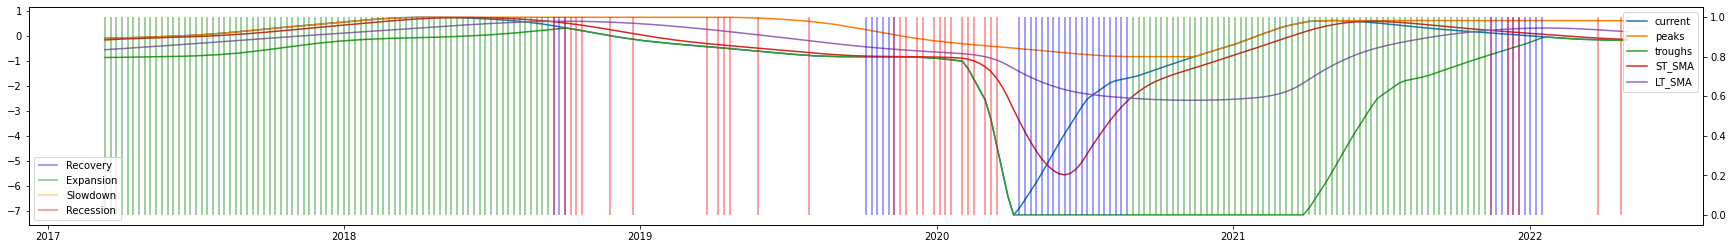

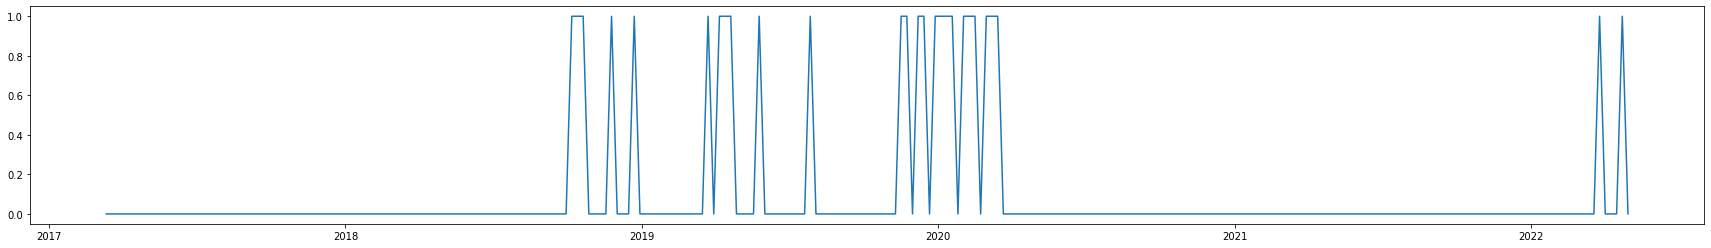

In [62]:

fig, ax1 = plt.subplots( figsize=(30,4) )
plt.plot(Recession.reindex(combined_indexes_sectors_return_pvt_df.index))
#plt.legend(loc=1)
#plt.legend(loc=3)
plt.show()

In [63]:
#business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).style.applymap(highlight_cells)

,signal,signal_trough,signal_peak,signal_ST_SMA,signal_LT_SMA,recovery,expansion,slowdown,recession
2017-03-12 00:00:00,-0.091102,-0.859826,-0.091102,-0.157098,-0.549484,False,True,False,False
2017-03-19 00:00:00,-0.086018,-0.858643,-0.086018,-0.144064,-0.534603,False,True,False,False
2017-03-26 00:00:00,-0.080933,-0.857309,-0.080933,-0.132375,-0.519647,False,True,False,False
2017-04-02 00:00:00,-0.075826,-0.854177,-0.075826,-0.122029,-0.504618,False,True,False,False
2017-04-09 00:00:00,-0.069942,-0.850545,-0.069942,-0.112630,-0.489537,False,True,False,False
2017-04-16 00:00:00,-0.063705,-0.846914,-0.063705,-0.103898,-0.474405,False,True,False,False
2017-04-23 00:00:00,-0.057468,-0.843282,-0.057468,-0.095832,-0.459224,False,True,False,False
2017-04-30 00:00:00,-0.051232,-0.839860,-0.051232,-0.088432,-0.443992,False,True,False,False
2017-05-07 00:00:00,-0.043905,-0.836595,-0.043905,-0.081530,-0.428685,False,True,False,False
2017-05-14 00:00:00,-0.035125,-0.833329,-0.035125,-0.074703,-0.413272,False,True,False,False


In [64]:
business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).iloc[:,1:].sum(axis=1).max()

4.183787622197017

In [65]:
business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).iloc[:,1:].sum(axis=0)

signal_trough   -559.678806
signal_peak        76.24962
signal_ST_SMA   -118.336221
signal_LT_SMA   -129.457275
recovery                 99
expansion                82
slowdown                  0
recession                34
dtype: object

In [66]:
#today_minus_yesterday.map(lambda t: test_decreasing_value(t))

In [67]:
np.sum(business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).iloc[:,1:].sum(axis=0))

-516.2226816148251